# Root Finding

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


One thing we want to be able to do compare two different algorithms that compute the same result.

Many numerical algorithms operate through some sort of iterative process, where we get better and better approximations to the answer at each iteration.

One example of this is [Newton's method](https://en.wikipedia.org/wiki/Newton%27s_method) for root finding.  A **root** of a continuous function $f$ is a value $x$ so that $f(x) = 0$.

Given a function $f$, we would like to find some root $x$. Newton's method computes a sequence of iterations
$$ x_k = x_{k-1} - \frac{f(x_{k-1})}{f'(x_{k-1})}$$

In [2]:
def newton_root(f, fp, x=1, tol=1e-4):
    """
    numerically approximate a root of f using Newton's method
    """
    fx = f(x)
    iters = []
    fs = []
    while (abs(fx) > tol):
        x = x - fx / fp(x)
        fx = f(x)
        iters.append(x)
        fs.append(fx)
        
    return x, iters, fs

In [3]:
f = lambda x : x**2 - 2
fp = lambda x : 2*x

x , ix, iy = newton_root(f, fp)
print(x)

print(np.sqrt(2)) # roots are +- sqrt(2)

x, ix, iy = newton_root(f, fp, x=-1)
print(x)

1.4142156862745099
1.4142135623730951
-1.4142156862745099


Another root finding algorithm is the [bisection method](https://en.wikipedia.org/wiki/Bisection_method).  This operates by narrowing an interval which is known to contain a root.  Using the [intermediate value theorem](https://en.wikipedia.org/wiki/Intermediate_value_theorem), we know that if $f(a) < 0$, and $f(b) > 0$, there must be some $c\in (a,b)$ so that $f(c) = 0$.  At each iteration, we narrow the interval.

In [4]:
def bisection_root(f, lb=-1, ub=1, tol=1e-4):
    """
    numerically approximate a root of f using bisection method
    
    assume signs of f(inf), f(-inf) are different
    """
    # first increase range until signs of f(lb), f(ub) are different
    while f(lb) * f(ub) > 0:
        lb *= 2
        ub *= 2
        
        
    iters = []
    fs = []
    
    # see if we found a root with one of our bounds
    if abs(f(lb)) < tol:
        return lb, iters, fs
    if abs(f(ub)) < tol:
        return ub, iters, fs
        
    # make lb correspond to negative sign
    if f(lb) > 0:
        # swap upper and lower
        lb, ub = ub, lb
        
    while True:
        x = (ub + lb)/2.0 # mean
        iters.append(x)
        
        fx = f(x)
        fs.append(fx)
        if abs(fx) < tol:
            # found a root
            return x, iters, fs
        elif fx > 0:
            # f(x) > 0
            ub = x
        else:
            # f(x) < 0
            lb = x

In [5]:
f = lambda x : (x - 2)*(x + 3)*(x + 5)
x, ix, iy = bisection_root(f)
x

2

Let's test these two methods on the same function

In [6]:
f = lambda x : x**3 + 2*x**2 + 5*x + 1
fp = lambda x : 3*x**2 + 4*x + 5

tol = 1e-8

x_newton, iter_newton, f_newton = newton_root(f, fp, tol=tol)
x_bisect, iter_bisect, f_bisect = bisection_root(f, tol=tol)

x_newton, x_bisect

(-0.21675657195055742, -0.21675657108426094)

Let's see how many iterations each method performed

In [7]:
print(len(iter_newton))
print(len(iter_bisect))

5
29


It looks like one algorithm is converging faster than the other - let's track how close each iteration is to a root:

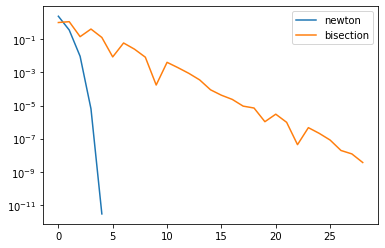

In [8]:
plt.semilogy(np.abs(f_newton), label="newton")
plt.semilogy(np.abs(f_bisect), label="bisection")
plt.legend()
plt.show()

## An Application of Decorators

While Newton's method converges faster, it required us to provide the derivative of the function we're trying to find a root for.  This might not always be easy to implement.

Instead, we might consider numerically approximating the derivative.  Recall
$$f'(x) = \lim_{h\to 0^+} \frac{f(x) - f(x + h)}{h}$$
We'll use the symmetric definition
$$f'(x) = \lim_{h\to 0^+} \frac{f(x+h) - f(x - h)}{2h}$$

Let's define a non-limit version
$$\Delta_h f(x) = \frac{f(x + h) - f(x - h)}{2h}$$
for fixed $x$, if $h$ is sufficiently small, then $\Delta_h f \approx f'$ near $x$

We can explicitly define a numerical derivative of a function $f$ via

In [9]:
def delta(f, h=1e-8):
    
    def wrapper(x):
        return (f(x + h) - f(x - h))/(2*h)
    
    return wrapper

In [10]:
f = lambda x : (x - np.sqrt(2))*np.exp(-x**2)
fp = delta(f)

In [11]:
x_newton, iter_newton, f_newton = newton_root(f, fp, tol=1e-6)

we might also consider defining a decorator that returns $f(x), \Delta_h(x)$ from a function definition

In [13]:
from functools import wraps

def add_numerical_derivative(f, default_h=1e-8):
    
    @wraps(f)
    def wrapper(x, h=default_h):
        ret = f(x)
        deriv = (f(x + h) - f(x - h)) / (2*h)
        return ret, deriv
    
    return wrapper
        
@add_numerical_derivative
def f(x):
    return (x - np.sqrt(2))*np.exp(-x**2)

f(0.5) # returns value, numerical derivative

(-0.7119902382706651, 1.4907910239614353)

In [14]:
f(0.5, h=1e-7)

(-0.7119902382706651, 1.4907910206307662)